## Work
- 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
from keras.datasets import cifar10
import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [3]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [4]:
from keras.layers import BatchNormalization, Activation, Dropout
from keras import regularizers

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128],
              use_bn=True, drp_ratio=0., l2_ratio=0.):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Activation("relu")(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)

        else:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(x)
            x = Activation("relu")(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [5]:
# 設定超參數
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 256
USE_BN = [True, False]
DRP_RATIO = [0., 0.2, 0.4]
L2_RATIO = [0., 1e-4, 1e-8]

In [6]:
results = {}

import itertools
for use_bn, drp_ratio, l2_ratio in itertools.product(USE_BN, DRP_RATIO, L2_RATIO):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(f"Batch Normalization: {use_bn}, Dropout ratio: {drp_ratio}, L2 regularization ratio: {l2_ratio}")
    model = build_mlp(input_shape=x_train.shape[1:], use_bn=use_bn, drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = (f"Batch Normalization: {use_bn}, Dropout ratio: {drp_ratio}, L2 regularization ratio: {l2_ratio}")
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Batch Normalization: True, Dropout ratio: 0.0, L2 regularization ratio: 0.0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 256)           

 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 activation_2 (Activation)   (None, 128)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total para

Epoch 2/30
196/196 [==============================] - 7s 34ms/step - loss: 1.4763 - accuracy: 0.4783 - val_loss: 2.0697 - val_accuracy: 0.3288
Epoch 3/30
196/196 [==============================] - 7s 34ms/step - loss: 1.3832 - accuracy: 0.5104 - val_loss: 1.7372 - val_accuracy: 0.3859
Epoch 4/30
196/196 [==============================] - 7s 35ms/step - loss: 1.3133 - accuracy: 0.5350 - val_loss: 1.6913 - val_accuracy: 0.4057
Epoch 5/30
196/196 [==============================] - 7s 35ms/step - loss: 1.2507 - accuracy: 0.5575 - val_loss: 1.9014 - val_accuracy: 0.3700
Epoch 6/30
196/196 [==============================] - 7s 36ms/step - loss: 1.2105 - accuracy: 0.5690 - val_loss: 1.9075 - val_accuracy: 0.3804
Epoch 7/30
196/196 [==============================] - 7s 36ms/step - loss: 1.1718 - accuracy: 0.5836 - val_loss: 1.7693 - val_accuracy: 0.3962
Epoch 8/30
196/196 [==============================] - 7s 35ms/step - loss: 1.1334 - accuracy: 0.5979 - val_loss: 1.6165 - val_accuracy: 0.4514

196/196 [==============================] - 7s 34ms/step - loss: 1.4241 - accuracy: 0.5189 - val_loss: 1.5536 - val_accuracy: 0.4771
Epoch 21/30
196/196 [==============================] - 7s 34ms/step - loss: 1.4290 - accuracy: 0.5155 - val_loss: 2.4278 - val_accuracy: 0.2120
Epoch 22/30
196/196 [==============================] - 7s 35ms/step - loss: 1.4274 - accuracy: 0.5197 - val_loss: 1.7275 - val_accuracy: 0.3904
Epoch 23/30
196/196 [==============================] - 7s 34ms/step - loss: 1.4142 - accuracy: 0.5235 - val_loss: 1.5107 - val_accuracy: 0.4816
Epoch 24/30
196/196 [==============================] - 7s 35ms/step - loss: 1.4019 - accuracy: 0.5251 - val_loss: 1.7434 - val_accuracy: 0.4126
Epoch 25/30
196/196 [==============================] - 7s 35ms/step - loss: 1.4024 - accuracy: 0.5268 - val_loss: 1.4876 - val_accuracy: 0.4944
Epoch 26/30
196/196 [==============================] - 7s 36ms/step - loss: 1.3861 - accuracy: 0.5362 - val_loss: 1.5265 - val_accuracy: 0.4814
Epoc

                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 activation_2 (Activation)   (None, 128)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_2

Trainable params: 1,740,682
Non-trainable params: 1,792
_________________________________________________________________
Epoch 1/30
196/196 [==============================] - 8s 36ms/step - loss: 2.2119 - accuracy: 0.2695 - val_loss: 1.8207 - val_accuracy: 0.3551
Epoch 2/30
196/196 [==============================] - 7s 37ms/step - loss: 1.8408 - accuracy: 0.3448 - val_loss: 1.9599 - val_accuracy: 0.3100
Epoch 3/30
196/196 [==============================] - 7s 37ms/step - loss: 1.7332 - accuracy: 0.3793 - val_loss: 1.9003 - val_accuracy: 0.3288
Epoch 4/30
196/196 [==============================] - 7s 36ms/step - loss: 1.6779 - accuracy: 0.3968 - val_loss: 1.6810 - val_accuracy: 0.3903
Epoch 5/30
196/196 [==============================] - 7s 36ms/step - loss: 1.6440 - accuracy: 0.4139 - val_loss: 1.5788 - val_accuracy: 0.4279
Epoch 6/30
196/196 [==============================] - 7s 35ms/step - loss: 1.6269 - accuracy: 0.4165 - val_loss: 1.7005 - val_accuracy: 0.3904
Epoch 7/30
196/196 [

196/196 [==============================] - 5s 27ms/step - loss: 1.1842 - accuracy: 0.6043 - val_loss: 1.4216 - val_accuracy: 0.5246
Epoch 27/30
196/196 [==============================] - 6s 29ms/step - loss: 1.1693 - accuracy: 0.6118 - val_loss: 1.4442 - val_accuracy: 0.5214
Epoch 28/30
196/196 [==============================] - 5s 27ms/step - loss: 1.1698 - accuracy: 0.6103 - val_loss: 1.4544 - val_accuracy: 0.5259
Epoch 29/30
196/196 [==============================] - 5s 28ms/step - loss: 1.1571 - accuracy: 0.6153 - val_loss: 1.4434 - val_accuracy: 0.5254
Epoch 30/30
196/196 [==============================] - 5s 27ms/step - loss: 1.1349 - accuracy: 0.6233 - val_loss: 1.4297 - val_accuracy: 0.5375
Batch Normalization: False, Dropout ratio: 0.0, L2 regularization ratio: 1e-08
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         


                                                                 
 activation_2 (Activation)   (None, 128)               0         
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
196/196 [==============================] - 9s 37ms/step - loss: 2.0393 - accuracy: 0.2476 - val_loss: 1.7962 - val_accuracy: 0.3508
Epoch 2/30
196/196 [==============================] - 6s 31ms/step - loss: 1.8544 - accuracy: 0.3282 - val_loss: 1.7292 - val_accuracy: 0.3839
Epoch 3/30
196/196 [==============================] - 6s 31ms/step - loss: 1.7878 - accuracy: 0.3545 - val_los

Epoch 10/30
196/196 [==============================] - 7s 34ms/step - loss: 1.6473 - accuracy: 0.4220 - val_loss: 1.5865 - val_accuracy: 0.4589
Epoch 11/30
196/196 [==============================] - 7s 33ms/step - loss: 1.6376 - accuracy: 0.4248 - val_loss: 1.5608 - val_accuracy: 0.4639
Epoch 12/30
196/196 [==============================] - 6s 32ms/step - loss: 1.6296 - accuracy: 0.4272 - val_loss: 1.5628 - val_accuracy: 0.4638
Epoch 13/30
196/196 [==============================] - 6s 32ms/step - loss: 1.6128 - accuracy: 0.4355 - val_loss: 1.5509 - val_accuracy: 0.4616
Epoch 14/30
196/196 [==============================] - 6s 32ms/step - loss: 1.6005 - accuracy: 0.4391 - val_loss: 1.5542 - val_accuracy: 0.4578
Epoch 15/30
196/196 [==============================] - 6s 32ms/step - loss: 1.5973 - accuracy: 0.4441 - val_loss: 1.5219 - val_accuracy: 0.4802
Epoch 16/30
196/196 [==============================] - 6s 33ms/step - loss: 1.5952 - accuracy: 0.4435 - val_loss: 1.5371 - val_accuracy:

 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 activation_2 (Activation)   (None, 128)               0         
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0


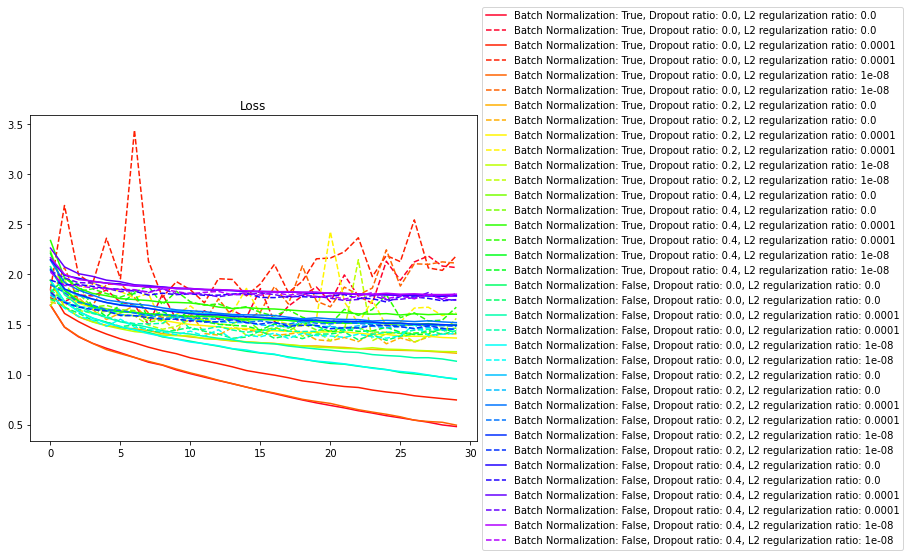

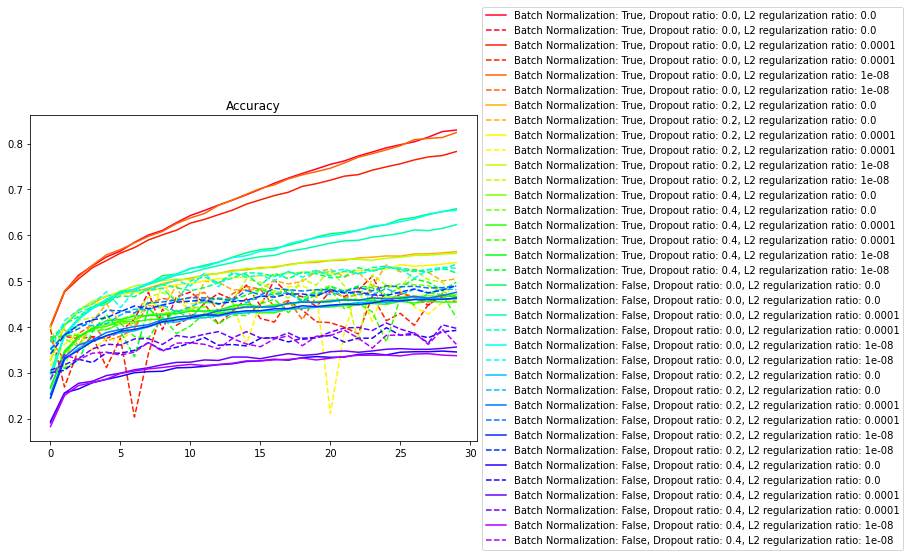

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()